In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Parcelwise PLS chapman with age and gender regression

In [5]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ---------------------------------------------------
# SETTINGS
# ---------------------------------------------------
parcel_cols = [f'node_{i+1}' for i in range(400)]

clinical_vars = [
    'Hypomanic_scale',
    'Perceptual_aberration_scale',
    'Physical_anhedonia_scale',
    'Social_anhedonia_scale',
    'Hopkins_depression_scale'
]

group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

covariate_cols = ['age', 'gender']

gradient_files = {
    'G1': './g1_aligned_chap.csv',
    'G2': './g2_aligned_chap.csv',
    'G3': './g3_aligned_chap.csv'
}

# target number of LVs
requested_n_components = 3

results = {}

# ---------------------------------------------------
# HELPER FUNCTIONS
# ---------------------------------------------------
def regress_out(X, covariates):
    """
    Regress out covariates from each brain feature (column of X).
    X: n × p matrix (subjects × parcels)
    covariates: n × k matrix (e.g., age, gender)
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender or diagnosis) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


# ---------------------------------------------------
# MAIN LOOP OVER GRADIENTS
# ---------------------------------------------------
for grad_name, file_path in gradient_files.items():
    print(f"\n=== Processing {grad_name} ===")

    # Load gradient file
    df = pd.read_csv(file_path)

    # Encode gender numerically (and diagnosis if present)
    for col in ['gender', 'diagnosis']:
        if col in df.columns:
            df = ensure_numeric_encoding(df, col)

    # -------------------------------
    # Create cognitive domain scores
    # -------------------------------
    for group_name, var_list in group_definitions.items():
        missing = [v for v in var_list if v not in df.columns]
        if missing:
            raise KeyError(f"Missing cognitive variables for domain '{group_name}': {missing}")
        # Z-score each variable (population sd ddof=0), then average, invert so higher = worse
        zscored = df[var_list].apply(lambda col: (col - col.mean()) / col.std(ddof=0), axis=0)
        df[group_name] = -zscored.mean(axis=1)

    # -------------------------------
    # Extract imaging (X) and behavioral (Y)
    # -------------------------------
    X = df[parcel_cols].values
    Y_cols = clinical_vars + list(group_definitions.keys())
    Y = df[Y_cols].values

    # Remove subjects with missing data
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid = ~(nan_rows_X | nan_rows_Y)
    X_valid = X[valid]
    Y_valid = Y[valid]
    df_valid = df.loc[valid].copy()

    n_samples = X_valid.shape[0]
    n_features = X_valid.shape[1]
    n_behavs = Y_valid.shape[1]
    if n_samples == 0:
        raise ValueError(f"No valid subjects for gradient {grad_name} after dropping missing data.")

    # -------------------------------
    # Regress out age and gender from X
    # -------------------------------
    covars = df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # -------------------------------
    # Standardize X and Y
    # -------------------------------
    X_std = StandardScaler().fit_transform(X_resid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # -------------------------------
    # Determine number of components (safety)
    # -------------------------------
    # PLS components cannot exceed min(n_samples, n_features, n_behavs)
    max_possible_components = min(n_samples, n_features, n_behavs)
    n_components = min(requested_n_components, max_possible_components)
    if n_components < requested_n_components:
        print(f"Warning: requested {requested_n_components} components but will use {n_components} "
              f"(limited by data: samples={n_samples}, features={n_features}, behavs={n_behavs}).")

    # -------------------------------
    # Fit PLS (n_components)
    # -------------------------------
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_std, Y_std)

    # Extract scores and saliences (matrices: columns = components)
    X_scores = pls.x_scores_         # shape (n_samples, n_components)
    Y_scores = pls.y_scores_         # shape (n_samples, n_components)
    X_saliences = pls.x_weights_     # shape (n_features, n_components)
    Y_saliences = pls.y_weights_     # shape (n_behavs, n_components)

    # -------------------------------
    # Compute behavioral correlations: each behavior × each LV
    # store r and p
    # -------------------------------
    behav_corrs = pd.DataFrame(index=Y_cols,
                               columns=[f'LV{c+1}_r' for c in range(n_components)] +
                                       [f'LV{c+1}_p' for c in range(n_components)],
                               dtype=float)

    for i, var in enumerate(Y_cols):
        for c in range(n_components):
            r, p = pearsonr(Y_std[:, i], Y_scores[:, c])
            behav_corrs.loc[var, f'LV{c+1}_r'] = r
            behav_corrs.loc[var, f'LV{c+1}_p'] = p

    # -------------------------------
    # Save results
    # -------------------------------
    results[grad_name] = {
        'n_components': n_components,
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid,
        'df_valid': df_valid,
        'X_std': X_std,
        'Y_std': Y_std,
        'pls_object': pls
    }

    # -------------------------------
    # Print summary per LV
    # -------------------------------
    print(f"{grad_name} — PLS summary (higher behavior values = worse performance):")
    for c in range(n_components):
        print(f"\n LV{c+1}:")
        # top behavioral correlations (by absolute r)
        lv_r_col = f'LV{c+1}_r'
        behav_sorted = behav_corrs[lv_r_col].abs().sort_values(ascending=False)
        top_behavs = behav_sorted.index.tolist()
        # show top 5 behaviors with sign
        print("  Top behavior correlations (abs r):")
        for var in top_behavs[:5]:
            r = behav_corrs.loc[var, lv_r_col]
            p = behav_corrs.loc[var, f'LV{c+1}_p']
            print(f"    {var:30s}: r = {r:6.3f}")

print("\nAll gradients processed. Results stored in `results` dict.")



=== Processing G1 ===
G1 — PLS summary (higher behavior values = worse performance):

 LV1:
  Top behavior correlations (abs r):
    Perceptual_aberration_scale   : r =  0.710
    VerbalLearning_Memory         : r =  0.685
    Attention_WorkingMemory       : r =  0.647
    Verbal_Comprehension          : r =  0.608
    Reasoning_ProblemSolving      : r =  0.607

 LV2:
  Top behavior correlations (abs r):
    Perceptual_aberration_scale   : r = -0.680
    Attention_WorkingMemory       : r = -0.617
    Verbal_Comprehension          : r = -0.597
    Reasoning_ProblemSolving      : r = -0.579
    VerbalLearning_Memory         : r = -0.572

 LV3:
  Top behavior correlations (abs r):
    Attention_WorkingMemory       : r = -0.572
    Perceptual_aberration_scale   : r = -0.572
    Reasoning_ProblemSolving      : r = -0.544
    VerbalLearning_Memory         : r = -0.485
    Verbal_Comprehension          : r = -0.471

=== Processing G2 ===
G2 — PLS summary (higher behavior values = worse perfo

## Cortical projection


=== Plotting G1 (3 latent variables) ===


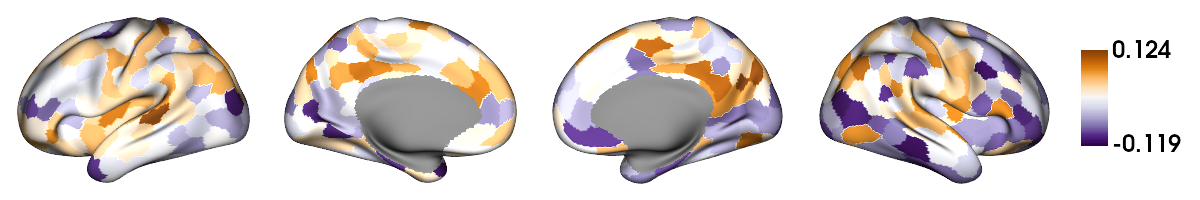

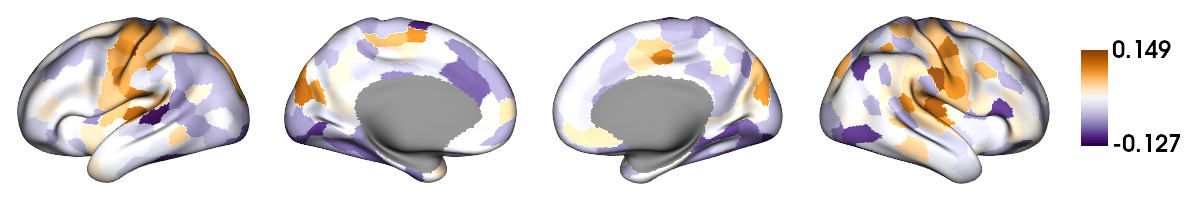

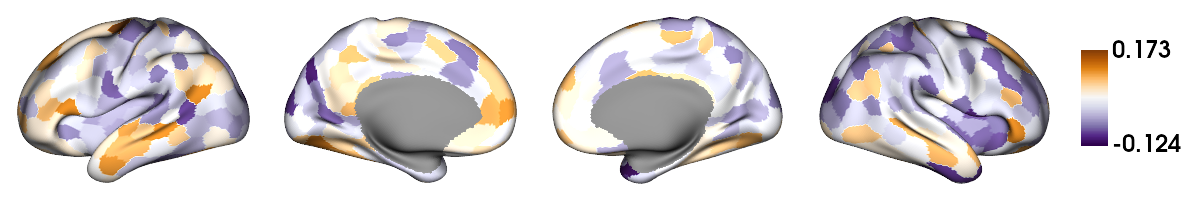


=== Plotting G2 (3 latent variables) ===


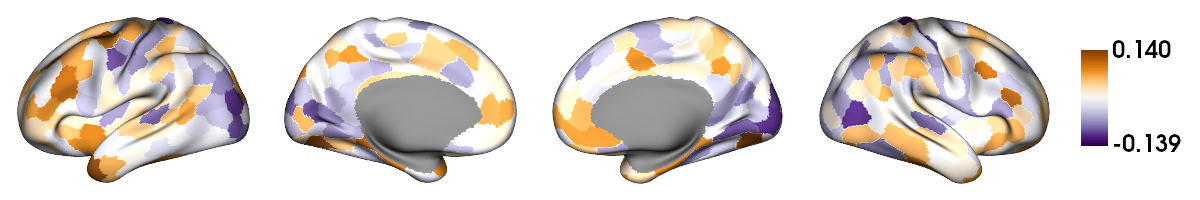

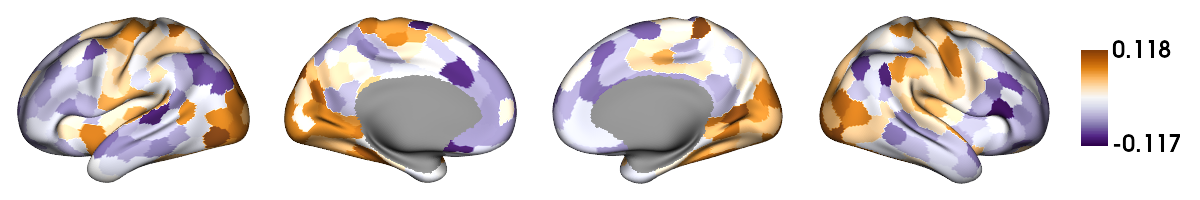

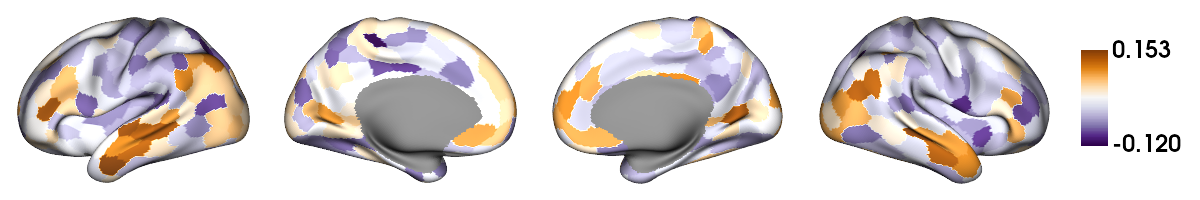


=== Plotting G3 (3 latent variables) ===


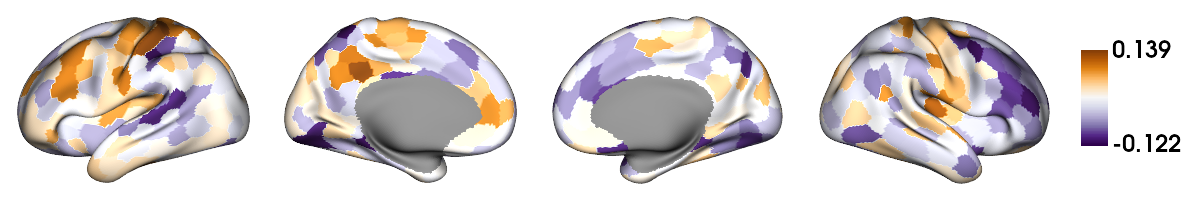

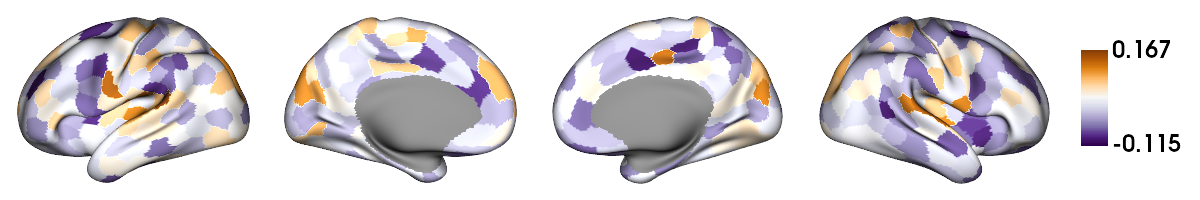

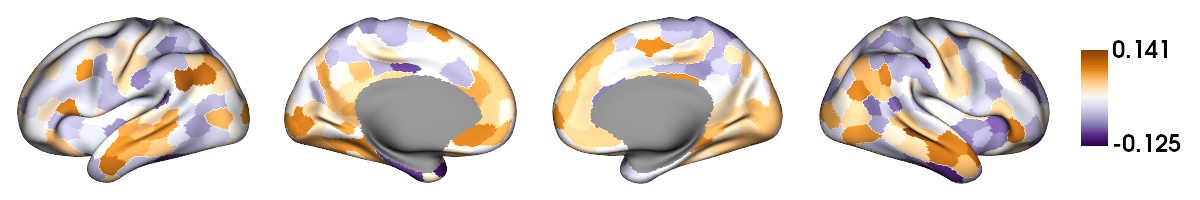

✅ Gradient LV1–LV3 cortical maps saved to 'new_figures/'


In [6]:
from IPython.display import Image, display
import numpy as np
import os

# Ensure output folder exists
os.makedirs("new_figures", exist_ok=True)

# Loop through all gradients in the new PLS results (including controls)
for grad_name, res in results.items():
    X_saliences = res['X_saliences']  # shape: (n_parcels, n_components)
    n_components = res['n_components']

    print(f"\n=== Plotting {grad_name} ({n_components} latent variables) ===")

    # Loop over each LV
    for lv in range(n_components):
        # Extract saliences for this LV
        lv_sal = X_saliences[:, lv]

        # Create brain map: NaN everywhere except labeled parcels
        brain_map = np.full_like(atlas, np.nan, dtype=float)
        for j in range(len(lv_sal)):
            brain_map[atlas == j + 1] = lv_sal[j]
        brain_map[atlas == 0] = np.nan  # mask background / non-cortex

        # Define output filename (includes gradient name and LV number)
        filename = f'./new_figures/{grad_name}_LV{lv+1}_map_cortex_chap.png'

        # Plot cortical surface (using your custom plotting function)
        fp.plot_surface(
            data=[brain_map],
            size=(1200, 200),
            cmap='PuOr_r',
            display=False,  # Save instead of showing interactively
            filename=filename
        )

        # Display saved image inline (optional)
        display(Image(filename))

print("✅ Gradient LV1–LV3 cortical maps saved to 'new_figures/'")


## Permutation testing

In [7]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
results_perm = {}        # store permutation results

# -------------------------------
# Main loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"\nPermutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = res['X_std']  # standardized brain data (residualized + z-scored)
    Y = res['Y_std']  # standardized behavioral data
    n_components = res['n_components']

    # -------------------------------
    # Observed PLS (non-permuted)
    # -------------------------------
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    # Compute observed singular values (covariance of X and Y scores per LV)
    obs_singular_values = np.zeros(n_components)
    for lv in range(n_components):
        X_scores = pls.x_scores_[:, lv]
        Y_scores = pls.y_scores_[:, lv]
        obs_singular_values[lv] = np.cov(X_scores, Y_scores, bias=True)[0, 1]

    # -------------------------------
    # Permutation null distribution
    # -------------------------------
    perm_singular_values = np.zeros((n_permutations, n_components))
    for i in range(n_permutations):
        # Shuffle subjects (break brain–behavior correspondence)
        X_perm = X[np.random.permutation(X.shape[0]), :]

        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)

        for lv in range(n_components):
            X_scores_perm = pls_perm.x_scores_[:, lv]
            Y_scores_perm = pls_perm.y_scores_[:, lv]
            perm_singular_values[i, lv] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # -------------------------------
    # Compute one-tailed p-values (perm >= observed)
    # -------------------------------
    p_values = np.mean(perm_singular_values >= obs_singular_values, axis=0)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_values': obs_singular_values,
        'perm_singular_values': perm_singular_values,
        'p_values': p_values
    }

    # Print results per LV
    for lv in range(n_components):
        print(f"{grad_name} LV{lv+1} permutation p-value: {p_values[lv]:.4f}")

print("\n✅ Permutation testing complete. Results stored in `results_perm`.")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.2550
G1 LV2 permutation p-value: 0.4022
G1 LV3 permutation p-value: 0.8991

Permutation testing for G2...
G2 LV1 permutation p-value: 0.5465
G2 LV2 permutation p-value: 0.1649
G2 LV3 permutation p-value: 0.7066

Permutation testing for G3...
G3 LV1 permutation p-value: 0.5412
G3 LV2 permutation p-value: 0.3881
G3 LV3 permutation p-value: 0.0744

✅ Permutation testing complete. Results stored in `results_perm`.


## Bootstrap resampling


Bootstrap resampling for G1...


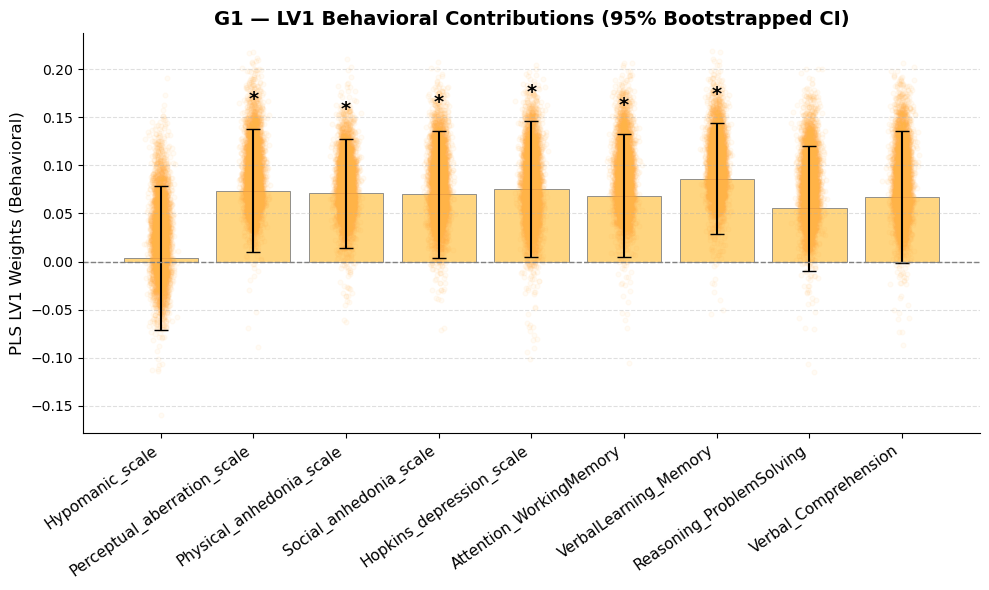

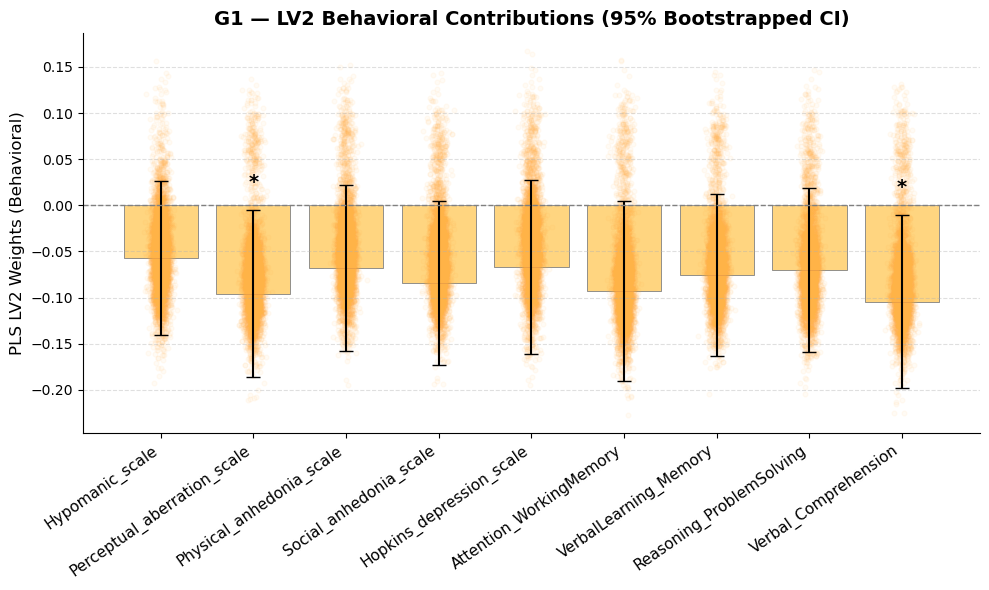

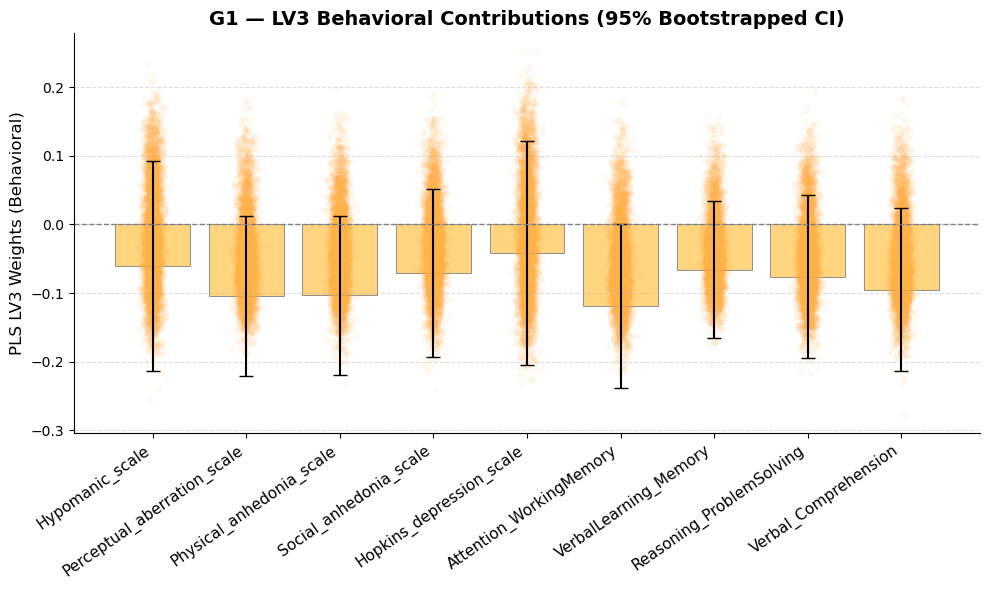


Bootstrap resampling for G2...


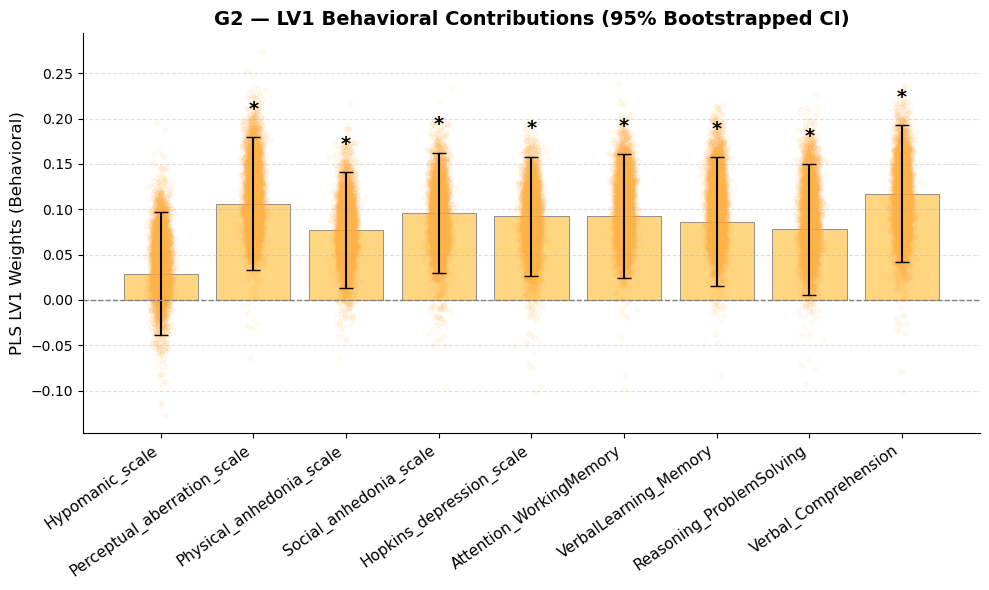

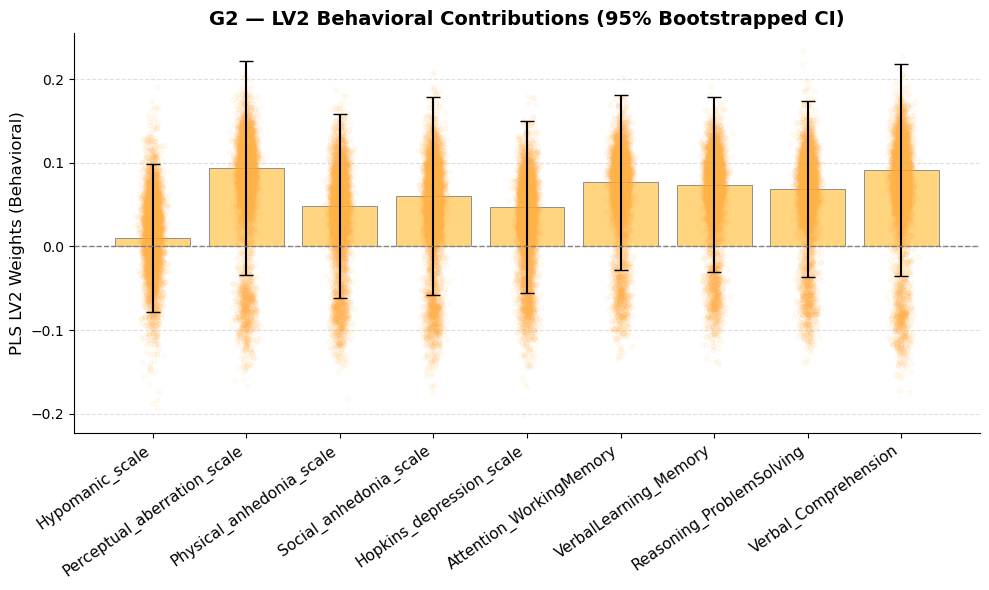

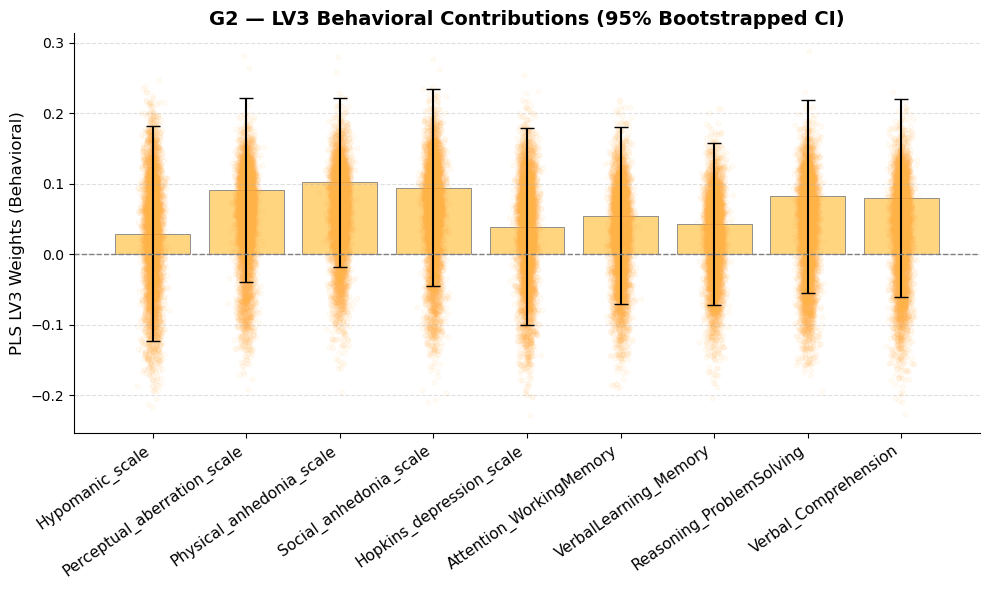


Bootstrap resampling for G3...


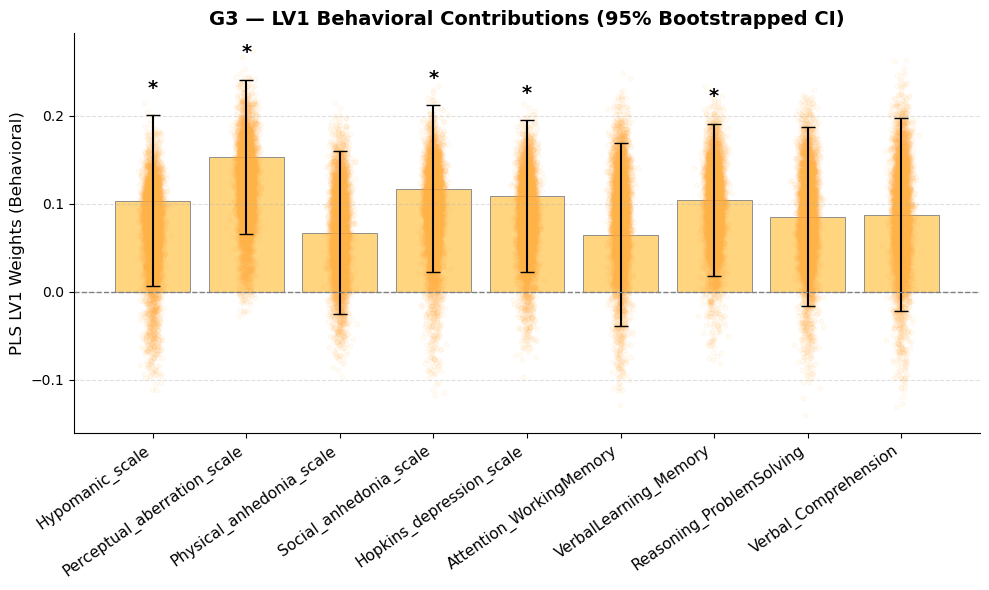

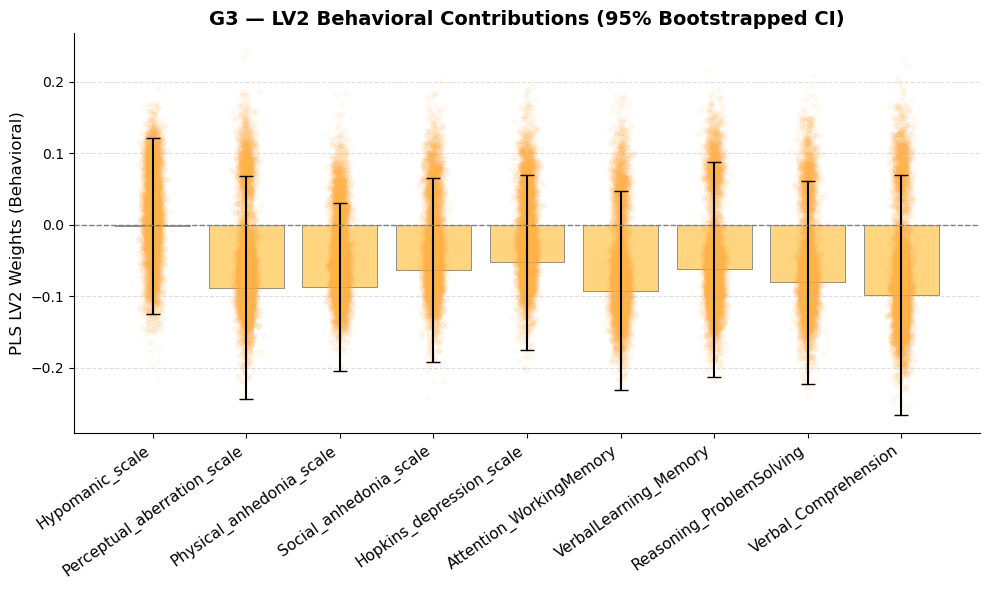

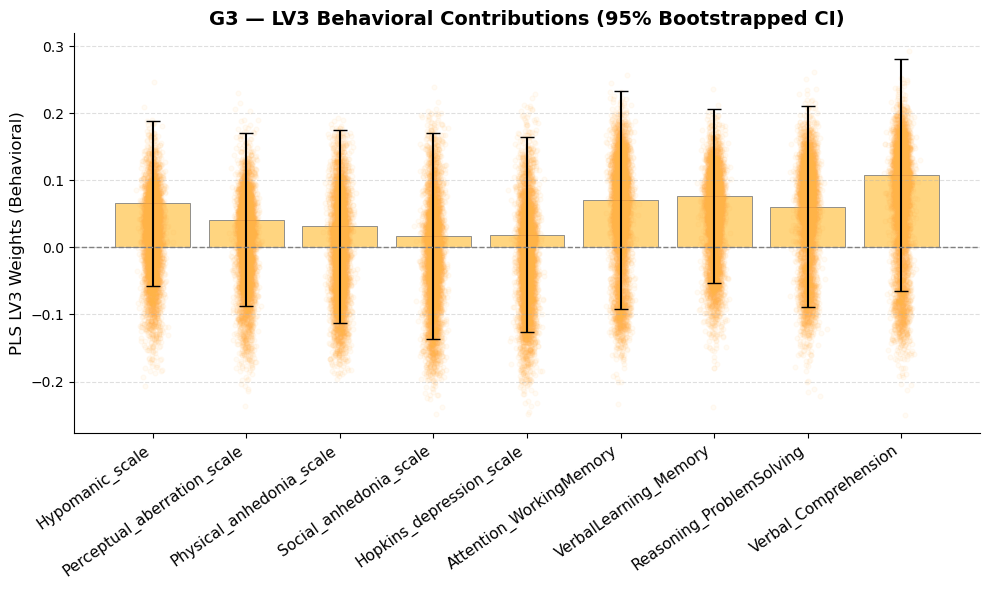


✅ Bootstrap resampling complete. Results stored in `results_boot`.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000   # number of bootstrap resamples
results_boot = {}     # store bootstrap outputs

# Colors for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"\nBootstrap resampling for {grad_name}...")

    # Standardized data from new analysis (residualized, z-scored)
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]
    n_components = res['n_components']

    # ----------------------------------
    # Original PLS with all components
    # ----------------------------------
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_      # shape: (voxels × components)
    Y_orig_weights = pls_orig.y_weights_      # shape: (behaviors × components)

    # Initialize bootstrap arrays
    X_boot_weights = np.zeros((n_bootstrap, n_voxels, n_components))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav, n_components))

    # ----------------------------------
    # Bootstrap resampling
    # ----------------------------------
    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)

        # Align sign for each LV separately
        for lv in range(n_components):
            Xb_w = pls_boot.x_weights_[:, lv]
            Yb_w = pls_boot.y_weights_[:, lv]
            if np.dot(Xb_w, X_orig_weights[:, lv]) < 0:
                Xb_w *= -1
                Yb_w *= -1
            X_boot_weights[i, :, lv] = Xb_w
            Y_boot_weights[i, :, lv] = Yb_w

    # ----------------------------------
    # Compute bootstrap ratios (BSRs) per LV
    # ----------------------------------
    X_bsr = np.zeros_like(X_orig_weights)
    Y_bsr = np.zeros_like(Y_orig_weights)

    for lv in range(n_components):
        X_bsr[:, lv] = X_orig_weights[:, lv] / X_boot_weights[:, :, lv].std(axis=0)
        Y_bsr[:, lv] = Y_orig_weights[:, lv] / Y_boot_weights[:, :, lv].std(axis=0)

    # Store all bootstrap results
    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # ----------------------------------
    # Behavioral contribution plots per LV
    # ----------------------------------
    Y_cols = list(res['behav_corrs'].index)

    for lv in range(n_components):
        y_mean = Y_orig_weights[:, lv]
        y_sd = Y_boot_weights[:, :, lv].std(axis=0)
        lower_ci = y_mean - 1.96 * y_sd
        upper_ci = y_mean + 1.96 * y_sd
        significant = (lower_ci > 0) | (upper_ci < 0)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Bars with 95% CI
        bars = ax.bar(np.arange(n_behav), y_mean,
                      width=0.8,
                      yerr=[y_mean - lower_ci, upper_ci - y_mean],
                      capsize=5, color=bar_color, edgecolor='gray', linewidth=0.6)

        # Overlay bootstrap points
        for j in range(n_behav):
            x_jitter = np.random.normal(j, 0.05, size=n_bootstrap)
            ax.scatter(x_jitter, Y_boot_weights[:, j, lv],
                       color=point_color, alpha=0.05, s=12)

        # Zero reference line
        ax.axhline(0, color='gray', linestyle='--', linewidth=1)

        # Add significance stars
        for j, sig in enumerate(significant):
            if sig:
                ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                        fontsize=14, color=star_color, fontweight='bold')

        # Formatting
        ax.set_xticks(np.arange(n_behav))
        ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=11)
        ax.set_ylabel(f'PLS LV{lv+1} Weights (Behavioral)', fontsize=12)
        ax.set_title(f'{grad_name} — LV{lv+1} Behavioral Contributions (95% Bootstrapped CI)',
                     fontsize=14, fontweight='bold')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', alpha=0.4)
        ax.xaxis.grid(False)

        plt.tight_layout()
        plt.show()

print("\n✅ Bootstrap resampling complete. Results stored in `results_boot`.")


## New variance explained

Computing variance explained for CHAP-based PLS across all gradients (LV1–LV3)...

G1 — LV1:
  Explains 7.07% of X variance, 6.45% of Y variance, 84.72% of X–Y cross-covariance energy, and latent t–u r² = 18.96%
G1 — LV2:
  Explains 4.46% of X variance, 7.98% of Y variance, 66.12% of X–Y cross-covariance energy, and latent t–u r² = 27.53%
G1 — LV3:
  Explains 3.30% of X variance, 5.81% of Y variance, 35.67% of X–Y cross-covariance energy, and latent t–u r² = 27.98%

G2 — LV1:
  Explains 5.58% of X variance, 7.87% of Y variance, 88.00% of X–Y cross-covariance energy, and latent t–u r² = 22.76%
G2 — LV2:
  Explains 5.29% of X variance, 6.80% of Y variance, 72.08% of X–Y cross-covariance energy, and latent t–u r² = 25.30%
G2 — LV3:
  Explains 3.91% of X variance, 5.02% of Y variance, 39.29% of X–Y cross-covariance energy, and latent t–u r² = 25.33%

G3 — LV1:
  Explains 4.36% of X variance, 9.06% of Y variance, 68.51% of X–Y cross-covariance energy, and latent t–u r² = 26.95%
G3 — LV2:
  

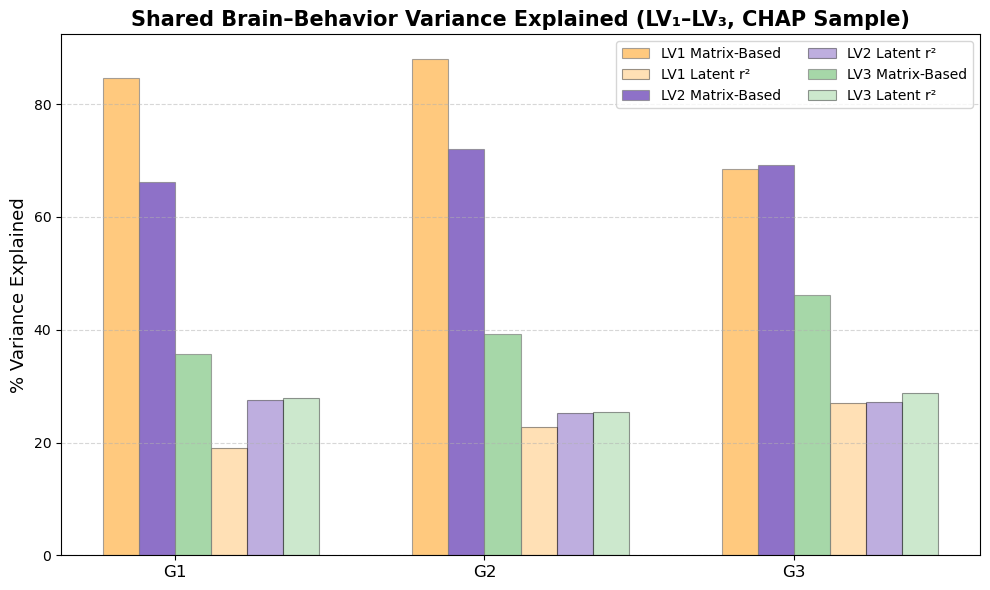


✅ CHAP variance explained analysis complete for all LVs. Results stored in `var_explained_dict`.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# -------------------------------------
# Create output folder if not exists
# -------------------------------------
os.makedirs("new_figures", exist_ok=True)

# -------------------------------------
# Initialize dictionary
# -------------------------------------
var_explained_dict = {}

print("Computing variance explained for CHAP-based PLS across all gradients (LV1–LV3)...\n")

# -------------------------------------
# Loop through all gradient-based PLS
# -------------------------------------
for grad_name, res in results.items():
    X = res['X_std']  # standardized brain data
    Y = res['Y_std']  # standardized behavioral/clinical data
    n_samples = X.shape[0]
    n_components = res['n_components']

    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)

    var_X_expl_all = []
    var_Y_expl_all = []
    shared_var_matrix_all = []
    r2_latent_all = []

    # -------------------------------------
    # Loop through all LVs
    # -------------------------------------
    for lv in range(n_components):
        # Predicted data reconstruction for this LV only
        X_pred = np.outer(pls.x_scores_[:, lv], pls.x_loadings_[:, lv])
        Y_pred = np.outer(pls.x_scores_[:, lv], pls.y_loadings_[:, lv])

        # Variance explained (block-specific)
        var_X_expl = np.sum(X_pred**2) / np.sum(X**2)
        var_Y_expl = np.sum(Y_pred**2) / np.sum(Y**2)

        # Shared variance (matrix-based approach)
        C_full = (X.T @ Y) / (n_samples - 1)
        C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
        total_cross_energy = np.sum(C_full**2)
        explained_cross_energy = np.sum(C_pred**2)
        shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

        # Latent score correlation (r²)
        t = pls.x_scores_[:, lv]
        u = pls.y_scores_[:, lv]
        r2_latent = np.corrcoef(t, u)[0, 1] ** 2

        var_X_expl_all.append(var_X_expl)
        var_Y_expl_all.append(var_Y_expl)
        shared_var_matrix_all.append(shared_var_matrix)
        r2_latent_all.append(r2_latent)

        print(f"{grad_name} — LV{lv+1}:")
        print(f"  Explains {var_X_expl * 100:.2f}% of X variance, "
              f"{var_Y_expl * 100:.2f}% of Y variance, "
              f"{shared_var_matrix * 100:.2f}% of X–Y cross-covariance energy, "
              f"and latent t–u r² = {r2_latent * 100:.2f}%")

    print("")

    # Store results
    var_explained_dict[grad_name] = {
        'X_var%': np.array(var_X_expl_all) * 100,
        'Y_var%': np.array(var_Y_expl_all) * 100,
        'Shared_matrix%': np.array(shared_var_matrix_all) * 100,
        'r2_latent%': np.array(r2_latent_all) * 100
    }

# -------------------------------------
# Combined bar plot (Matrix vs Latent r²) for all LVs
# -------------------------------------
grad_names = list(var_explained_dict.keys())
n_grads = len(grad_names)
n_components = len(var_explained_dict[grad_names[0]]['Shared_matrix%'])

x = np.arange(n_grads)
width = 0.35
colors = ['#FFB347', '#5E35B1', '#81C784']  # LV1, LV2, LV3 colors

plt.figure(figsize=(10, 6))
for lv in range(n_components):
    matrix_vals = [var_explained_dict[g]['Shared_matrix%'][lv] for g in grad_names]
    latent_vals = [var_explained_dict[g]['r2_latent%'][lv] for g in grad_names]

    plt.bar(x - width/2 + lv*(width/n_components), matrix_vals, width/n_components,
            label=f'LV{lv+1} Matrix-Based', color=colors[lv], edgecolor='gray', linewidth=0.8, alpha=0.7)
    plt.bar(x + width/2 + lv*(width/n_components), latent_vals, width/n_components,
            label=f'LV{lv+1} Latent r²', color=colors[lv], edgecolor='black', linewidth=0.8, alpha=0.4)

# Labels and formatting
plt.xticks(x, grad_names, fontsize=12)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁–LV₃, CHAP Sample)",
          fontsize=15, fontweight='bold')
plt.ylim(0, None)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1-3.png", dpi=300)
plt.show()

print("\n✅ CHAP variance explained analysis complete for all LVs. Results stored in `var_explained_dict`.")


## Cross validation

Running cross-validation + permutation testing for CHAP PLS results (LV₁–LV₃)...


Cross-validating G1...
  Using 5-fold CV with 20 repeats.
  LV1 cross-validation...
    Observed out-of-sample correlation (LV1): r = 0.050


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV1 permutation p-value = 0.2720
  LV2 cross-validation...
    Observed out-of-sample correlation (LV2): r = -0.128


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV2 permutation p-value = 0.8900
  LV3 cross-validation...
    Observed out-of-sample correlation (LV3): r = 0.147


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV3 permutation p-value = 0.1210

Cross-validating G2...
  Using 5-fold CV with 20 repeats.
  LV1 cross-validation...
    Observed out-of-sample correlation (LV1): r = 0.042


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV1 permutation p-value = 0.2830
  LV2 cross-validation...
    Observed out-of-sample correlation (LV2): r = -0.186


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV2 permutation p-value = 0.9560
  LV3 cross-validation...
    Observed out-of-sample correlation (LV3): r = 0.026


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV3 permutation p-value = 0.4430

Cross-validating G3...
  Using 5-fold CV with 20 repeats.
  LV1 cross-validation...
    Observed out-of-sample correlation (LV1): r = 0.026


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV1 permutation p-value = 0.3650
  LV2 cross-validation...
    Observed out-of-sample correlation (LV2): r = 0.020


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV2 permutation p-value = 0.5710
  LV3 cross-validation...
    Observed out-of-sample correlation (LV3): r = -0.080


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


    → LV3 permutation p-value = 0.7120


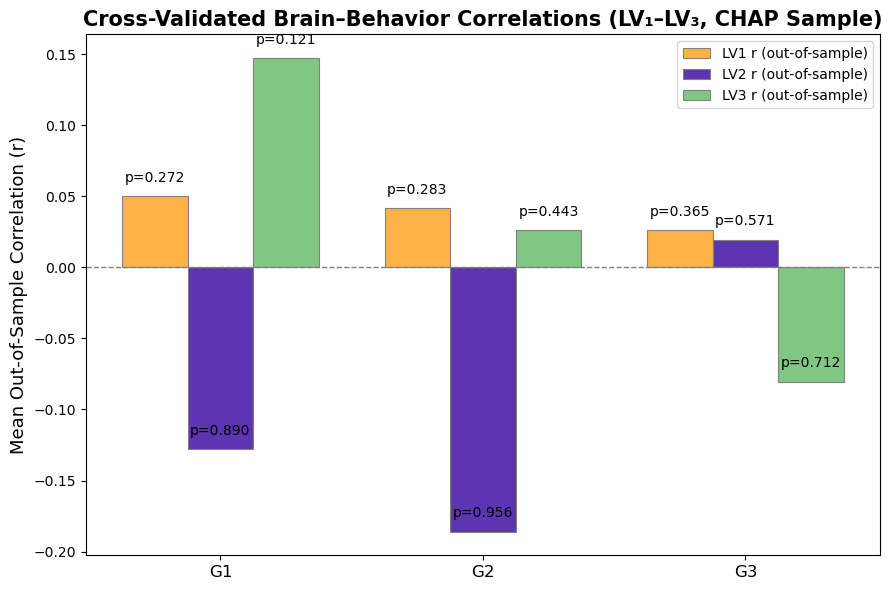


✅ CHAP cross-validation and permutation results for all LVs stored in `cv_results`.


In [11]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# SETUP
# --------------------------------------------------
os.makedirs("new_figures", exist_ok=True)

n_splits = 5          # folds for larger samples
n_repeats = 20        # repeated KFold iterations
n_perm = 1000         # number of permutations
random_state = 42

cv_results = {}

print("Running cross-validation + permutation testing for CHAP PLS results (LV₁–LV₃)...\n")

# --------------------------------------------------
# CROSS-VALIDATION PER GRADIENT
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res["X_std"]
    Y = res["Y_std"]
    n = X.shape[0]
    n_components = res["n_components"]

    # Choose appropriate CV strategy
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    grad_cv_data = {}

    # --------------------------------------------------
    # Loop over latent variables
    # --------------------------------------------------
    for lv in range(n_components):
        print(f"  LV{lv+1} cross-validation...")

        all_x_pred = np.zeros(n)
        all_y_pred = np.zeros(n)

        # Cross-validation
        if use_loocv:
            loo = LeaveOneOut()
            for train_idx, test_idx in loo.split(X):
                pls = PLSRegression(n_components=n_components)
                pls.fit(X[train_idx], Y[train_idx])
                all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, lv]
                all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, lv]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=n_components)
                    pls.fit(X[train_idx], Y[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, lv]
                    temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, lv]
            all_x_pred = temp_x_pred.mean(axis=0)
            all_y_pred = temp_y_pred.mean(axis=0)

        # Observed correlation
        observed_r, _ = pearsonr(all_x_pred, all_y_pred)
        print(f"    Observed out-of-sample correlation (LV{lv+1}): r = {observed_r:.3f}")

        # --------------------------------------------------
        # Permutation testing
        # --------------------------------------------------
        perm_corrs = np.zeros(n_perm)
        for perm in range(n_perm):
            Y_perm = Y[np.random.permutation(n)]

            if use_loocv:
                perm_x_pred = np.zeros(n)
                perm_y_pred = np.zeros(n)
                for test_idx in range(n):
                    train_idx = np.setdiff1d(np.arange(n), test_idx)
                    pls = PLSRegression(n_components=n_components)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, lv]
                    perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, lv]
            else:
                temp_x_pred = np.zeros((n_repeats_eff, n))
                temp_y_pred = np.zeros((n_repeats_eff, n))
                for rep in range(n_repeats_eff):
                    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                    for train_idx, test_idx in kf.split(X):
                        pls = PLSRegression(n_components=n_components)
                        pls.fit(X[train_idx], Y_perm[train_idx])
                        temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, lv]
                        temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, lv]
                perm_x_pred = temp_x_pred.mean(axis=0)
                perm_y_pred = temp_y_pred.mean(axis=0)

            r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
            perm_corrs[perm] = r_perm

        pval = np.mean(perm_corrs >= observed_r)
        print(f"    → LV{lv+1} permutation p-value = {pval:.4f}")

        grad_cv_data[f"LV{lv+1}"] = {
            "observed_r": observed_r,
            "perm_corrs": perm_corrs,
            "pval": pval,
        }

    cv_results[grad_name] = grad_cv_data

# --------------------------------------------------
# PLOT SUMMARY RESULTS
# --------------------------------------------------
grad_names = list(cv_results.keys())
lv_labels = list(cv_results[grad_names[0]].keys())
n_lv = len(lv_labels)

x = np.arange(len(grad_names))
width = 0.25
colors = ['#FFB347', '#5E35B1', '#81C784']

plt.figure(figsize=(9, 6))
for i, lv in enumerate(lv_labels):
    r_vals = [cv_results[g][lv]["observed_r"] for g in grad_names]
    plt.bar(x + i * width - width, r_vals, width=width, color=colors[i],
            label=f'{lv} r (out-of-sample)', edgecolor='gray', linewidth=0.8)

# Annotate with p-values
for i, grad in enumerate(grad_names):
    for j, lv in enumerate(lv_labels):
        r = cv_results[grad][lv]["observed_r"]
        p = cv_results[grad][lv]["pval"]
        plt.text(i + j * width - width, r + 0.01, f"p={p:.3f}",
                 ha="center", fontsize=10)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xticks(x, grad_names, fontsize=12)
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=13)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁–LV₃, CHAP Sample)",
          fontsize=15, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations_LV1-3.png", dpi=300)
plt.show()

print("\n✅ CHAP cross-validation and permutation results for all LVs stored in `cv_results`.")


## Split half resampling

Running split-half stability analysis for CHAP PLS results (LV₁–LV₃)...


Split-half resampling for G1...
  LV1 Brain pattern stability (mean r): 0.120
  LV1 Behavioral pattern stability (mean r): 0.100
  LV2 Brain pattern stability (mean r): 0.388
  LV2 Behavioral pattern stability (mean r): -0.136
  LV3 Brain pattern stability (mean r): 0.114
  LV3 Behavioral pattern stability (mean r): -0.200

Split-half resampling for G2...
  LV1 Brain pattern stability (mean r): 0.084
  LV1 Behavioral pattern stability (mean r): -0.069
  LV2 Brain pattern stability (mean r): 0.288
  LV2 Behavioral pattern stability (mean r): 0.052
  LV3 Brain pattern stability (mean r): 0.159
  LV3 Behavioral pattern stability (mean r): -0.176

Split-half resampling for G3...
  LV1 Brain pattern stability (mean r): 0.087
  LV1 Behavioral pattern stability (mean r): -0.011
  LV2 Brain pattern stability (mean r): 0.293
  LV2 Behavioral pattern stability (mean r): 0.143
  LV3 Brain pattern stability (mean r): 0.209
 

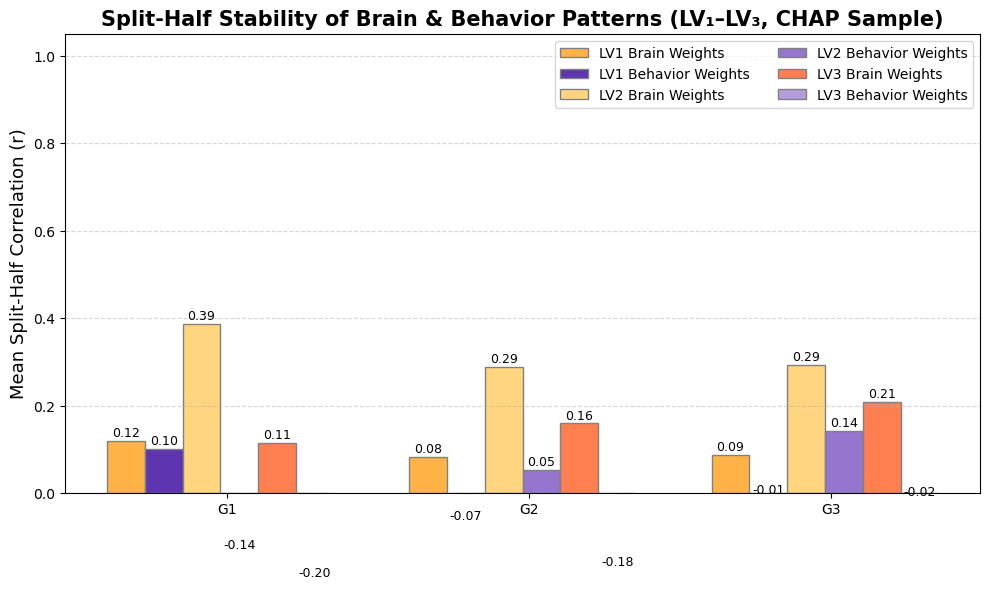


✅ Split-half stability results for all LVs stored in `stability_results` and figure saved to new_figures/.


In [10]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import os

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 100  # number of random split-half resamplings
random_state = 42
rng = np.random.default_rng(random_state)

os.makedirs("new_figures", exist_ok=True)
stability_results = {}

print("Running split-half stability analysis for CHAP PLS results (LV₁–LV₃)...\n")

# --------------------------------------------------
# LOOP OVER GRADIENTS
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res["X_std"]
    Y = res["Y_std"]
    n = X.shape[0]
    n_components = res["n_components"]

    grad_stability = {}

    # Loop over latent variables
    for lv in range(n_components):
        brain_corrs = []
        behav_corrs = []

        for split in range(n_splits):
            # Random split indices
            idx = rng.permutation(n)
            half = n // 2
            idx1, idx2 = idx[:half], idx[half:]

            # Fit PLS on first half
            pls1 = PLSRegression(n_components=n_components)
            pls1.fit(X[idx1], Y[idx1])
            U1 = pls1.x_weights_[:, lv]
            V1 = pls1.y_weights_[:, lv]

            # Fit PLS on second half
            pls2 = PLSRegression(n_components=n_components)
            pls2.fit(X[idx2], Y[idx2])
            U2 = pls2.x_weights_[:, lv]
            V2 = pls2.y_weights_[:, lv]

            # Align signs for consistency
            if np.dot(U1, U2) < 0:
                U2 *= -1
                V2 *= -1

            # Compute correlations (stability)
            brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
            behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

        # Store LV-specific results
        grad_stability[f"LV{lv+1}"] = {
            "brain_stability": np.mean(brain_corrs),
            "behav_stability": np.mean(behav_corrs),
            "brain_corrs_all": brain_corrs,
            "behav_corrs_all": behav_corrs,
        }

        print(f"  LV{lv+1} Brain pattern stability (mean r): {np.mean(brain_corrs):.3f}")
        print(f"  LV{lv+1} Behavioral pattern stability (mean r): {np.mean(behav_corrs):.3f}")

    stability_results[grad_name] = grad_stability

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
grad_names = list(stability_results.keys())
lv_labels = list(stability_results[grad_names[0]].keys())
n_lv = len(lv_labels)
x = np.arange(len(grad_names))

width = 0.25
colors_brain = ['#FFB347', '#FFD580', '#FF7F50']
colors_behav = ['#5E35B1', '#9575CD', '#B39DDB']

plt.figure(figsize=(10, 6))

for i, lv in enumerate(lv_labels):
    brain_vals = [stability_results[g][lv]["brain_stability"] for g in grad_names]
    behav_vals = [stability_results[g][lv]["behav_stability"] for g in grad_names]

    plt.bar(x + i * width - width, brain_vals, width / 2, label=f"{lv} Brain Weights", color=colors_brain[i], edgecolor="gray")
    plt.bar(x + i * width - width / 2, behav_vals, width / 2, label=f"{lv} Behavior Weights", color=colors_behav[i], edgecolor="gray")

    # Annotate means
    for j, g in enumerate(grad_names):
        plt.text(x[j] + i * width - width, brain_vals[j] + 0.01, f"{brain_vals[j]:.2f}", ha="center", fontsize=9)
        plt.text(x[j] + i * width - width / 2, behav_vals[j] + 0.01, f"{behav_vals[j]:.2f}", ha="center", fontsize=9)

plt.xticks(x + width / 3, grad_names)
plt.ylim(0, 1.05)
plt.ylabel("Mean Split-Half Correlation (r)", fontsize=13)
plt.title("Split-Half Stability of Brain & Behavior Patterns (LV₁–LV₃, CHAP Sample)", fontsize=15, fontweight="bold")
plt.legend(ncol=2, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/split_half_stability_LV1-3.png", dpi=300)
plt.show()

print("\n✅ Split-half stability results for all LVs stored in `stability_results` and figure saved to new_figures/.")
